In [1]:
import os
import PyPDF2
import fitz
import pandas as pd

In [2]:
from nltk import tokenize
# import nltk
# nltk.download('punkt')

In [3]:
dir = 'annoted_sustainability_reports/Energy/'


### Extracting Sentences

In [4]:
# aggregated sentences per report
highlighted_num = []
highlighted_sentences = [] 
all_sentences = []
highlighted_label = []
all_label = []

# aggregated sentences of the entire industry (tokenizing highlighted_result & all_result)
rel_text = []
rel_label = []
all_text_final = []


x_label = ["Total", "BP", "Shell"]

for file in os.listdir(dir): # running all the files in the industry folder
    f = os.path.join(dir, file) # joining filename and directory
    print(f)
    
    # labelling sentences by companies 
    res = list(filter(lambda x:  x in f, x_label))

    doc = fitz.open(f) # opening each company report
    print(doc)
    
    # results of each report
    highlighted_result = []
    all_result = [] 
    
    # Iterate each page of the document 
    for page in doc:
        
        # extract all the sentences in pdf 
        test = page.get_text()
        all_result.append(test)
        
        # extracting highlighted sentences from pdf 
        highlights = []
        annot = page.first_annot
        
        # https://medium.com/@vinitvaibhav9/extracting-pdf-highlights-using-python-9512af43a6d
        while annot:
            if annot.type[0] == 8:
                all_coordinates = annot.vertices
                try:
                    if len(all_coordinates) == 4:
                        highlight_coord = fitz.Quad(all_coordinates).rect
                        highlights.append(highlight_coord)
                    else:
                        all_coordinates = [all_coordinates[x:x+4] for x in range(0, len(all_coordinates), 4)]
                        for i in range(0,len(all_coordinates)):
                            coord = fitz.Quad(all_coordinates[i]).rect
                            highlights.append(coord)
                except:
                    print("NoneType found")
            annot = annot.next
        
        # calculate coordinate sum to eliminate duplicated sentences 
        coordinate_sum_total = []
        all_words = page.get_text_words()
        highlight_text = []
        if len(highlights) > 0:
            for h in highlights:
                sentence = []
                num_i = 0
                for w in all_words:
                    if (fitz.Rect(w[0:4]).intersects(h)):
                        if str(sum(w[0:4])) not in coordinate_sum_total: #if no duplicate coordinate sum found, append
                            coordinate_sum_total.append(str(sum(w[0:4])))
                            sentence.append(w[4])
            
                highlight_text.append(" ".join(sentence))
        
#         print(highlight_text)
        
        if len(highlight_text) > 0:
            highlighted_result.append(" ".join(highlight_text))
        
#         print(result)

    # Results of the entire industry & keeps track of number of sentences in highlighted_num
    highlighted_num.append(len(highlighted_result))
    highlighted_sentences.append(highlighted_result)
    all_sentences.append(all_result)
    
    print(len(highlighted_result))
    
#         print(test_text)
        
    for r in highlighted_result:
        if r is not None:
            # tokenize sentences by pages where the sentences is found 
            # instead of conducting it to the entire report this enhances accuracy 
            rel_text += tokenize.sent_tokenize(r)
            highlighted_label.append(res)
            rel_label += res * len(tokenize.sent_tokenize(r))         
    
    for i in all_result:
        all_text_final += tokenize.sent_tokenize(i.replace("\n", " "))
        all_label += res * len(tokenize.sent_tokenize(i.replace("\n", " ")))
        
#     print(highlighted_sentences, "\n", len(highlighted_sentences))



annoted_sustainability_reports/Energy/Total_2022_Sustainability_report.pdf
Document('annoted_sustainability_reports/Energy/Total_2022_Sustainability_report.pdf')
NoneType found
22
annoted_sustainability_reports/Energy/BP_2021_Sustainability_report.pdf
Document('annoted_sustainability_reports/Energy/BP_2021_Sustainability_report.pdf')
9
annoted_sustainability_reports/Energy/Shell_2021_Sustainability_report.pdf
Document('annoted_sustainability_reports/Energy/Shell_2021_Sustainability_report.pdf')
4


In [5]:
highlighted_num

[22, 9, 4]

In [6]:
rel_text_df = pd.DataFrame([rel_text, rel_label]).transpose()
rel_text_df = rel_text_df.rename(columns = {0: 'relevant_sentences', 1: 'company_label'})
rel_text_df

,relevant_sentences,company_label
0,We affirm our ambitious target of a more than ...,Total
1,"To that, we add phased targets for reducing me...",Total
2,otalEnergies is reducing the share of petro- l...,Total
3,The Company aims to produce 2 TWh per year of ...,Total
4,"In early 2021, TotalEnergies became a major pl...",Total
...,...,...
136,This new target covers all Scope 1 and 2 emiss...,Shell
137,These decreases were partly offset by higher e...,Shell
138,SCOPE 1 AND SCOPE 2 GHG EMISSIONS CHANGES FROM...,Shell
139,"In 2021, Shell’s total methane emissions were ...",Shell


In [7]:
all_text_final_df = pd.DataFrame([all_text_final, all_label]).transpose()
all_text_final_df = all_text_final_df.rename(columns = {0: 'all_sentences', 1: 'company_label'})
all_text_final_df

,all_sentences,company_label
0,MAGENTA YELLOW CYAN 30-34 Rue du Chemin Vert 7...,Total
1,TECHNIQUE TONS RECOMMANDÉS TOTAL TOT_21_00008_...,Total
2,"To that end, TotalEnergies leverages the princ...",Total
3,"Safety, operational excellence and sustainable...",Total
4,• Respect for each other is another TotalEner...,Total
...,...,...
3870,"CO2e (CO2 equivalent) refers to CO2, CH4, N2O.",Shell
3871,Divestments is a measure used to monitor the p...,Shell
3872,This measure comprises proceeds from sale of p...,Shell
3873,"Shell PurePlus, Shell Helix, Shell Rimula, She...",Shell


### Getting Sentence Statistics 

In [8]:
# count rel sentences 
rel_count = rel_text_df.groupby('company_label', sort = False).count()

# count all sentences
sent_count = all_text_final_df.groupby('company_label', sort = False).count()

In [9]:
sentences_list = []
rel_sent_list = []

final_text_stat = pd.concat([sent_count, rel_count],  sort = False, axis = 1)

[rel_sent_list.append(rel_sent) for rel_sent in final_text_stat['relevant_sentences']]    
[sentences_list.append(all_sent) for all_sent in final_text_stat['all_sentences']]    
    
final_text_stat['relevant_sentences'] = final_text_stat['relevant_sentences'].fillna(0)
final_text_stat['percentages'] = final_text_stat['relevant_sentences'] / final_text_stat['all_sentences'] * 100
final_text_stat

,all_sentences,relevant_sentences,percentages
company_label,,,
Total,1481,77,5.199190
BP,1216,51,4.194079
Shell,1178,13,1.103565


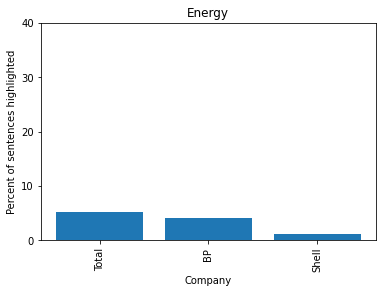

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import glob
y = []

x = ["Total", "BP", "Shell"]


i = 0

for file in os.listdir(dir):
    y.append(100 * (rel_sent_list[i])/sentences_list[i])
    i = i+1

plt.bar(x, y, width = 0.8)
plt.xticks(rotation='vertical')
plt.title("Energy")
plt.xlabel("Company")
plt.ylabel("Percent of sentences highlighted")
plt.yticks(np.arange(0, 50, 10))
plt.show()

In [11]:
import pandas as pd

series = pd.Series(y)
series.describe()

count    3.000000
mean     3.498945
std      2.134466
min      1.103565
25%      2.648822
50%      4.194079
75%      4.696634
max      5.199190
dtype: float64

### Exporting and Saving Files 

In [12]:
#storing variable so they can be called between notebooks (for aggregate analysis, test/train data sets, and modeling later on)

Energy_reltext = rel_text_df
Energy_alltext = all_text_final_df
Energy_stat = final_text_stat

%store Energy_reltext
%store Energy_alltext
%store Energy_stat

Stored 'Energy_reltext' (DataFrame)
Stored 'Energy_alltext' (DataFrame)
Stored 'Energy_stat' (DataFrame)
